In [153]:
import pandas as pd
import numpy as np

In [154]:

# Load the data
data = pd.read_csv('../cleaned_data/CGMacros.csv')
bio_data = pd.read_csv('../cleaned_data/bio.csv')
data['Timestamp'] = pd.to_timedelta(data['Timestamp'])


In [155]:
meal_data = data.dropna(subset=['Meal Type'])
meal_data = meal_data[meal_data['Meal Type'].isin(['breakfast', 'lunch'])]

In [156]:
meal_data

,Timestamp,Libre GL,HR,Calories (Activity),METs,Meal Type,Calories,Carbs,Protein,Fat,Fiber,Amount Consumed,PID
28,1 days 06:47:00,88.400000,81.0,3.14520,30.0,breakfast,448.0,66.0,22.0,10.5,0.0,100.0,1.0
43,1 days 10:29:00,82.000000,84.0,2.93552,28.0,lunch,840.0,89.0,17.0,42.0,3.0,100.0,1.0
132,2 days 07:36:00,86.266667,93.0,1.57260,15.0,breakfast,608.0,66.0,66.0,10.5,0.0,100.0,1.0
156,2 days 13:20:00,79.000000,96.0,2.72584,26.0,lunch,615.0,26.0,67.0,30.0,3.0,100.0,1.0
234,3 days 07:46:00,88.000000,92.0,6.91944,66.0,breakfast,712.0,66.0,22.0,42.0,0.0,100.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39033,7 days 13:07:00,113.533333,80.0,0.93130,10.0,lunch,585.0,40.0,76.0,17.0,13.0,100.0,49.0
39107,8 days 07:12:00,132.600000,80.0,0.93130,10.0,breakfast,712.0,66.0,22.0,42.0,0.0,100.0,49.0
39134,8 days 13:43:00,82.933333,93.0,1.02443,11.0,lunch,445.0,43.0,20.0,20.0,13.0,100.0,49.0
39206,9 days 07:12:00,138.333333,81.0,2.23512,24.0,breakfast,268.0,24.0,22.0,10.5,0.0,100.0,49.0


In [157]:
def calculate_metrics(data, meal_data):
    metrics = []

    for index, meal in meal_data.iterrows():
        meal_time = meal['Timestamp']
        baseline_glucose = meal['Libre GL']
        pid = meal['PID']
        
        # filter data
        post_meal_data = data[
            (data['PID'] == pid) &
            (data['Timestamp'] >= meal_time) &
            (data['Timestamp'] <= meal_time + pd.Timedelta(hours=3))
        ]

        # Time to Peak Glucose
        if not post_meal_data.empty:
            peak_glucose_row = post_meal_data.loc[post_meal_data['Libre GL'].idxmax()]
            peak_glucose_time = peak_glucose_row['Timestamp']
            time_to_peak_glucose = peak_glucose_time - meal_time

            # Glucose Excursion
            peak_glucose = peak_glucose_row['Libre GL']
            glucose_excursion = peak_glucose - baseline_glucose
            glucose_excursion_time = peak_glucose_time

            # Glucose Recovery Time
            recovery_data = post_meal_data[(post_meal_data['Timestamp'] >= peak_glucose_time) & (post_meal_data['Libre GL'] <= baseline_glucose)]

        

            if not recovery_data.empty:
                recovery_time = recovery_data.sort_values('Timestamp').iloc[0]['Timestamp']
                glucose_recovery_time = recovery_time - meal_time
            else:
                recovery_time = post_meal_data['Timestamp'].max()
                glucose_recovery_time = recovery_time - meal_time

            metrics.append({
                'PID': pid,
                'Meal Time': meal_time,
                'Meal Type': meal['Meal Type'],
                'Glucose Level at Meal Time': baseline_glucose,
                'Time to Peak Glucose': time_to_peak_glucose,
                'Glucose Excursion': glucose_excursion,
                'Glucose Excursion Time': glucose_excursion_time,
                'Glucose Recovery Time': glucose_recovery_time
            })

    return metrics

# Calculate metrics
metrics = calculate_metrics(data, meal_data)

In [158]:
# convert the metrics to a dataframe where each object is a row
metrics_df = pd.DataFrame(metrics)

In [159]:
agg_data = metrics_df.merge(bio_data[['PID', 'diabetes level']], on='PID', how='left')

In [160]:
# converting timedelta to minutes
agg_data['Time to Peak Glucose'] = agg_data['Time to Peak Glucose'].dt.total_seconds() / 60
agg_data['Glucose Recovery Time'] = agg_data['Glucose Recovery Time'].dt.total_seconds() / 60

In [161]:
agg_data.groupby(['diabetes level', 'Meal Type'])[[
    'Time to Peak Glucose', 'Glucose Excursion', 'Glucose Recovery Time']].agg(['mean', 'std'])

# 

Time to Peak Glucose            Glucose Excursion  \
                                         mean        std              mean   
diabetes level Meal Type                                                     
Diabetic       breakfast            70.370968  37.266884         96.091551   
               lunch                84.616000  56.693827         47.848533   
Non-diabetic   breakfast            54.193548  39.778386         36.569196   
               lunch                67.968254  48.110861         32.096825   
Pre-diabetic   breakfast            61.700000  42.432630         47.990476   
               lunch                70.244444  50.001264         43.486420   

                                    Glucose Recovery Time             
                                std                  mean        std  
diabetes level Meal Type                                              
Diabetic       breakfast  46.622509            146.895161  38.484464  
               lunch      45.384668            131.776000  67.781297  
Non-diabetic   breakfast  30.280235            118.064516  48.906039  
               lunch      28.653348            135.492063  58.975757  
Pre-diabetic   breakfast  31.127219            130.271429  47.847757  
               lunch      36.425167            145.733333  57.986772

In [162]:
agg_data

,PID,Meal Time,Meal Type,Glucose Level at Meal Time,Time to Peak Glucose,Glucose Excursion,Glucose Excursion Time,Glucose Recovery Time,diabetes level
0,1.0,1 days 06:47:00,breakfast,88.400000,28.0,27.733333,1 days 07:15:00,103.0,Non-diabetic
1,1.0,1 days 10:29:00,lunch,82.000000,31.0,17.800000,1 days 11:00:00,61.0,Non-diabetic
2,1.0,2 days 07:36:00,breakfast,86.266667,24.0,18.266667,2 days 08:00:00,84.0,Non-diabetic
3,1.0,2 days 13:20:00,lunch,79.000000,145.0,11.933333,2 days 15:45:00,175.0,Non-diabetic
4,1.0,3 days 07:46:00,breakfast,88.000000,29.0,24.933333,3 days 08:15:00,74.0,Non-diabetic
...,...,...,...,...,...,...,...,...,...
769,49.0,7 days 13:07:00,lunch,113.533333,98.0,39.800000,7 days 14:45:00,173.0,Diabetic
770,49.0,8 days 07:12:00,breakfast,132.600000,63.0,161.000000,8 days 08:15:00,168.0,Diabetic
771,49.0,8 days 13:43:00,lunch,82.933333,77.0,65.600000,8 days 15:00:00,167.0,Diabetic
772,49.0,9 days 07:12:00,breakfast,138.333333,48.0,85.866667,9 days 08:00:00,138.0,Diabetic


In [166]:
metrics_df

,PID,Meal Time,Meal Type,Glucose Level at Meal Time,Time to Peak Glucose,Glucose Excursion,Glucose Excursion Time,Glucose Recovery Time
0,1.0,1 days 06:47:00,breakfast,88.400000,0 days 00:28:00,27.733333,1 days 07:15:00,0 days 01:43:00
1,1.0,1 days 10:29:00,lunch,82.000000,0 days 00:31:00,17.800000,1 days 11:00:00,0 days 01:01:00
2,1.0,2 days 07:36:00,breakfast,86.266667,0 days 00:24:00,18.266667,2 days 08:00:00,0 days 01:24:00
3,1.0,2 days 13:20:00,lunch,79.000000,0 days 02:25:00,11.933333,2 days 15:45:00,0 days 02:55:00
4,1.0,3 days 07:46:00,breakfast,88.000000,0 days 00:29:00,24.933333,3 days 08:15:00,0 days 01:14:00
...,...,...,...,...,...,...,...,...
769,49.0,7 days 13:07:00,lunch,113.533333,0 days 01:38:00,39.800000,7 days 14:45:00,0 days 02:53:00
770,49.0,8 days 07:12:00,breakfast,132.600000,0 days 01:03:00,161.000000,8 days 08:15:00,0 days 02:48:00
771,49.0,8 days 13:43:00,lunch,82.933333,0 days 01:17:00,65.600000,8 days 15:00:00,0 days 02:47:00
772,49.0,9 days 07:12:00,breakfast,138.333333,0 days 00:48:00,85.866667,9 days 08:00:00,0 days 02:18:00


In [177]:
metrics_df = metrics_df[metrics_df['PID'] == 1.0]
data = data[data['PID'] == 1.0]

112500000000000 nanoseconds 6180000000000 nanoseconds 88.4 27.733333333333334


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

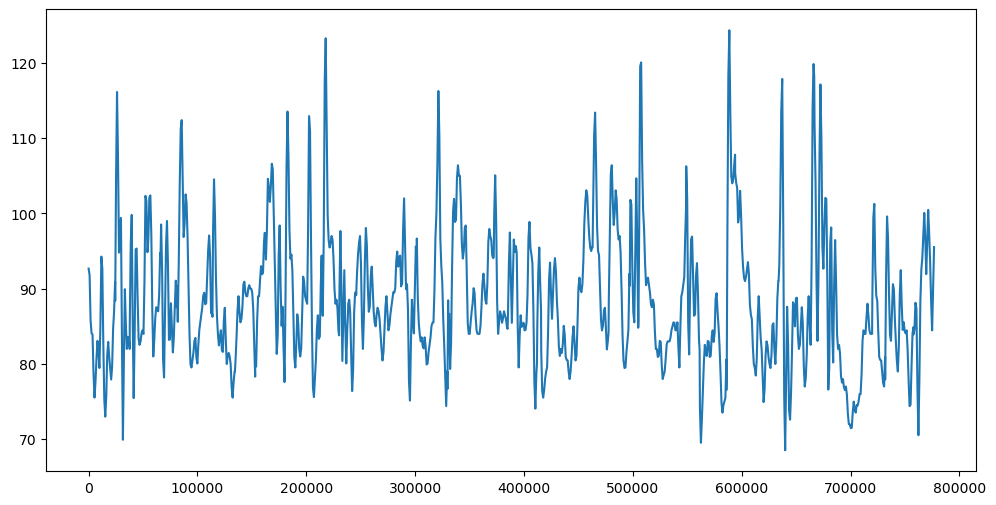

In [191]:
import matplotlib.pyplot as plt

pid = 1
pid_data = data[data['PID'] == pid]

# Convert timestamps to seconds
pid_data['Timestamp'] = (pid_data['Timestamp'] - pid_data['Timestamp'].min()).dt.total_seconds()

meal_time = metrics_df['Meal Time'].values[0]

glucose_excursion_time = metrics_df['Glucose Excursion Time'].values[0]
glucose_recovery_time = metrics_df['Glucose Recovery Time'].values[0]
glucose_level_at_meal_time = metrics_df['Glucose Level at Meal Time'].values[0]
glucose_excursion_level = metrics_df['Glucose Excursion'].values[0]
print(glucose_excursion_time, glucose_recovery_time, glucose_level_at_meal_time, glucose_excursion_level)
plt.figure(figsize=(12, 6))

# Plotting the glucose levels
plt.plot(pid_data['Timestamp'].values, pid_data['Libre GL'].values, label='Glucose Level')

# 1st horizontal line
plt.hlines(y=glucose_level_at_meal_time, xmin=meal_time, xmax=glucose_excursion_time, color='r', linestyle='--', label='Meal to Excursion')

# 2nd horizontal line
plt.hlines(y=glucose_level_at_meal_time, xmin=glucose_excursion_time, xmax=glucose_recovery_time, color='g', linestyle='--', label='Excursion to Recovery')

# 3rd vertical line
plt.vlines(x=glucose_excursion_time, ymin=glucose_level_at_meal_time, ymax=glucose_excursion_level, color='b', linestyle='--', label='Excursion Time')

plt.xlabel('Time (seconds)')
plt.ylabel('Glucose Level')
plt.legend()
plt.title('Glucose Levels with Meal and Excursion Times')
plt.show()

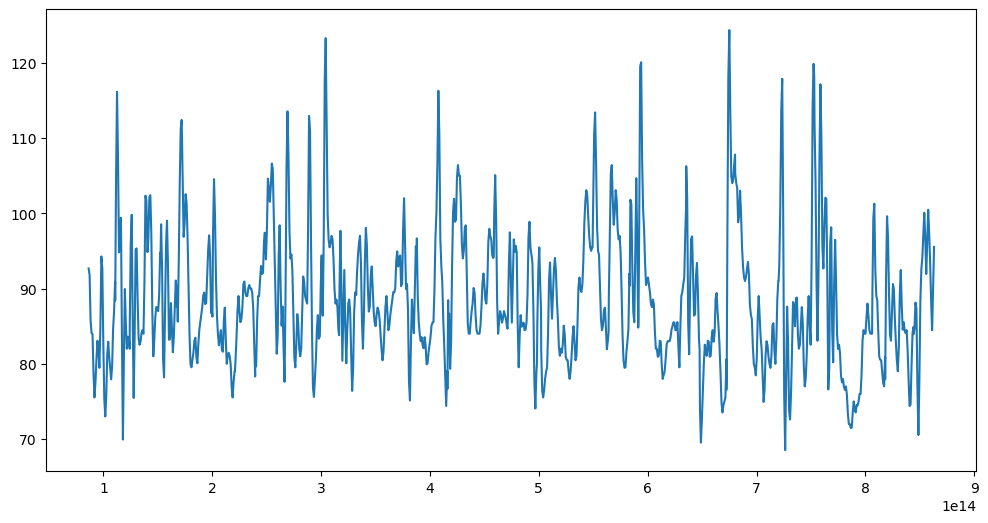

In [150]:
# plot the glucose trend of participants 1
import matplotlib.pyplot as plt

pid = 1
pid_data = data[data['PID'] == pid]

plt.figure(figsize=(12, 6))
plt.plot(pid_data['Timestamp'].values, pid_data['Libre GL'].values, label='Glucose Level')




In [118]:
metrics_df

,PID,Meal Time,Meal Type,Time to Peak Glucose,Glucose Excursion,Glucose Excursion Time,Glucose Recovery Time
0,1.0,1 days 06:47:00,breakfast,0 days 00:28:00,27.733333,1 days 07:15:00,0 days 01:43:00
1,1.0,1 days 10:29:00,lunch,0 days 00:31:00,17.800000,1 days 11:00:00,0 days 01:01:00
2,1.0,2 days 07:36:00,breakfast,0 days 00:24:00,18.266667,2 days 08:00:00,0 days 01:24:00
3,1.0,2 days 13:20:00,lunch,0 days 02:25:00,11.933333,2 days 15:45:00,0 days 02:55:00
4,1.0,3 days 07:46:00,breakfast,0 days 00:29:00,24.933333,3 days 08:15:00,0 days 01:14:00
...,...,...,...,...,...,...,...
769,49.0,7 days 13:07:00,lunch,0 days 01:38:00,39.800000,7 days 14:45:00,0 days 02:53:00
770,49.0,8 days 07:12:00,breakfast,0 days 01:03:00,161.000000,8 days 08:15:00,0 days 02:48:00
771,49.0,8 days 13:43:00,lunch,0 days 01:17:00,65.600000,8 days 15:00:00,0 days 02:47:00
772,49.0,9 days 07:12:00,breakfast,0 days 00:48:00,85.866667,9 days 08:00:00,0 days 02:18:00
